In [1]:
import pandas as pd

record = pd.read_csv('./result/pre_train/cnn_audio-mnist_record.csv')
record.head()

,Unnamed: 0,type,step,accuracy,loss
0,0,train,0,4.6875,2.303291
1,1,train,1,14.0625,2.299805
2,2,train,2,18.7500,2.299962
3,3,train,3,17.1875,2.296557
4,4,train,4,20.3125,2.295808


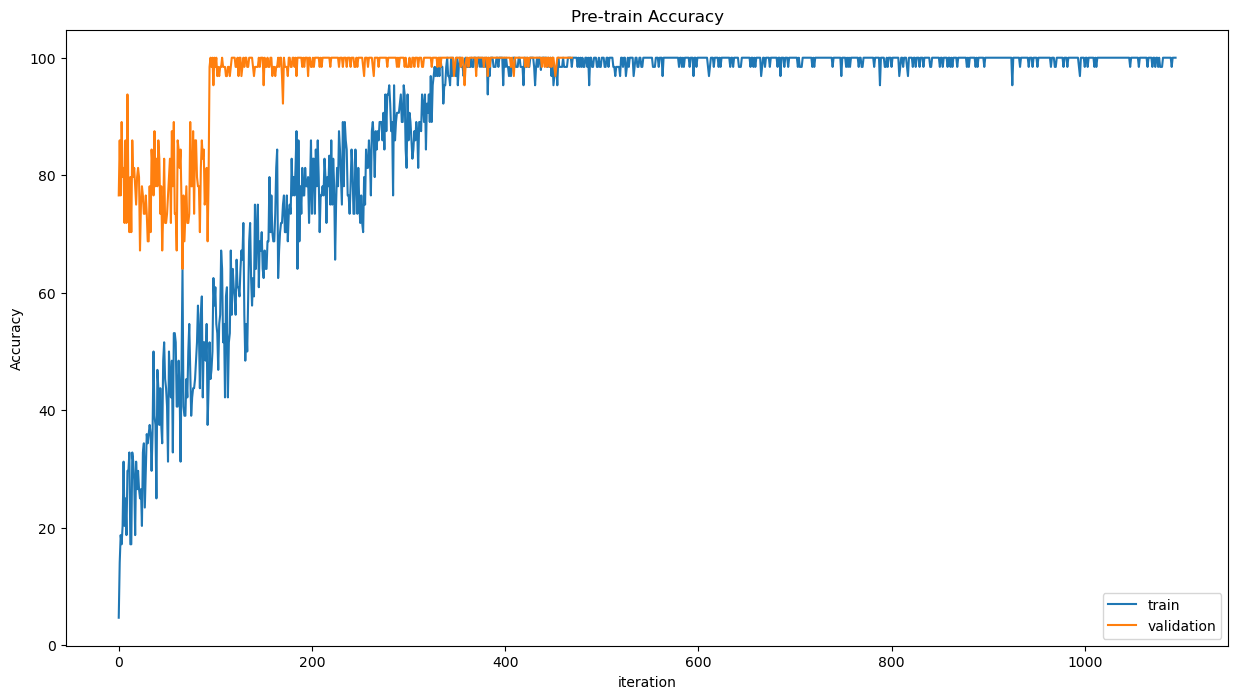

In [2]:
import matplotlib.pyplot as plt

train_record = record[record['type'] == 'train']
val_record = record[record['type'] == 'validation']
plt.figure(figsize=(15, 8))
plt.plot(train_record['step'], train_record['accuracy'], label='train')
plt.plot(val_record['step'], val_record['accuracy'], label='validation')
plt.xlabel('iteration')
plt.ylabel('Accuracy')
plt.title('Pre-train Accuracy')
plt.legend(loc='lower right')
plt.show()

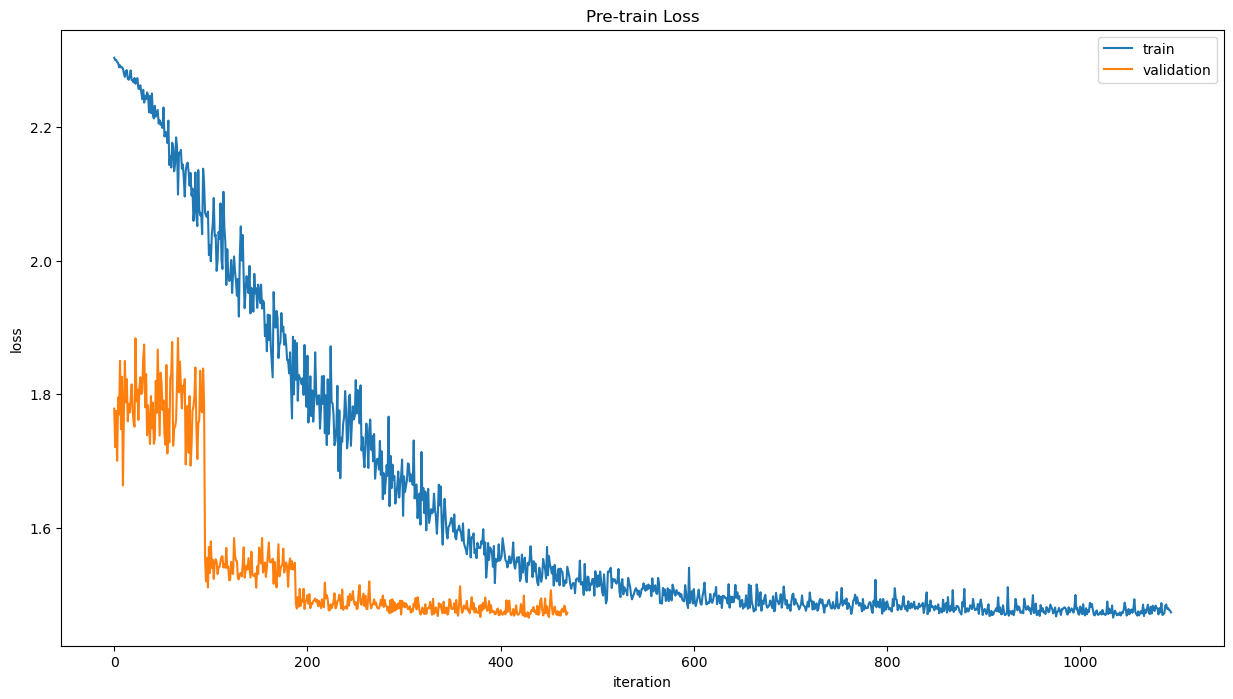

In [3]:
plt.figure(figsize=(15, 8))
plt.plot(train_record['step'], train_record['loss'], label='train')
plt.plot(val_record['step'], val_record['loss'], label='validation')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('Pre-train Loss')
plt.legend()
plt.show()

# Test dataset accuracy comparing

In [4]:
from lib.datasets import AudioMINST, load_datapath
from lib.wavUtils import Components, pad_trunc, time_shift, GuassianNoise
from lib.models import WavClassifier
import torch 
import torch.nn as nn
import torchaudio.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

accu_record = pd.DataFrame(columns=['dataset', 'algorithm', 'tta-operation', 'corruption', 'accuracy', 'error'])
n_mel = 64

def inference(model: nn.Module, loader: DataLoader, device: str) -> float:
    test_accu = 0.
    test_size = 0.
    test_iter = iter(loader)
    for iteration in tqdm(range(len(loader))):
        inputs, labels = next(test_iter)
        inputs, labels = inputs.cuda(), labels.cuda()
        outputs = model(inputs)
        _, preds = torch.max(outputs, dim=1)
        test_accu += (preds == labels).sum().cpu().item()
        test_size += labels.shape[0]
    return test_accu / test_size * 100.

def load_model(device='cuda') -> nn.Module:
    model = WavClassifier(class_num=10, l1_in_features=64, c1_in_channels=1).to(device=device)
    model.load_state_dict(torch.load('result/pre_train/cnn_audio-mnist.pt'))
    return model

sample_rate = 48000
data_transforms = Components(transforms=[
    pad_trunc(max_ms=1000, sample_rate=sample_rate),
    # time_shift(shift_limit=.1),
    transforms.MelSpectrogram(sample_rate=sample_rate, n_fft=1024, n_mels=n_mel),
    transforms.AmplitudeToDB(top_db=80),
    # transforms.FrequencyMasking(freq_mask_param=.1),
    # transforms.TimeMasking(time_mask_param=.1)
])
test_data_root_path = '/root/data/AudioMNIST/data'
test_datapathes = load_datapath(root_path=test_data_root_path, filter_fn=lambda x: x['accent']!= 'German')
test_dataset = AudioMINST(data_paths=test_datapathes, include_rate=False, data_trainsforms=data_transforms)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False, drop_last=False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = load_model(device)
model.eval()
original_test_accuracy = inference(model=model, loader=test_loader, device=device)
print(f'original test data size: {len(test_dataset)}, original test accuracy: {original_test_accuracy:.2f}%')
accu_record.loc[len(accu_record)] = ['Audio MNIST', 'cnn', 'N/A', 'N/A', original_test_accuracy, 100. - original_test_accuracy]

100%|██████████| 157/157 [02:21<00:00,  1.11it/s]

original test data size: 10000, original test accuracy: 97.15%


In [5]:
corrupted_data_transforms = Components(transforms=[
    pad_trunc(max_ms=1000, sample_rate=sample_rate),
    GuassianNoise(noise_level=.0025), # .025
    transforms.MelSpectrogram(sample_rate=sample_rate, n_fft=1024, n_mels=n_mel),
    transforms.AmplitudeToDB(top_db=80)
])
corrupted_test_dataset = AudioMINST(data_paths=test_datapathes, include_rate=False, data_trainsforms=corrupted_data_transforms)
corrupted_test_loader = DataLoader(dataset=corrupted_test_dataset, batch_size=64, shuffle=False, drop_last=False)

model = load_model(device)
model.eval()
corrupted_test_accuracy = inference(model=model, loader=corrupted_test_loader, device=device)
print(f'corrupted test data size: {len(corrupted_test_dataset)}, corrupted test accuracy: {corrupted_test_accuracy:.2f}%')
accu_record.loc[len(accu_record)] = ['Audio MNIST', 'cnn', 'N/A', 'Guassian Noise', corrupted_test_accuracy, 100. - corrupted_test_accuracy]

100%|██████████| 157/157 [02:39<00:00,  1.02s/it]

corrupted test data size: 10000, corrupted test accuracy: 12.37%


## 1. Tent Adaptation

In [6]:
import torch.optim as optim

from lib.tentAdapt import TentAdapt, get_params

tent_test_loader = DataLoader(dataset=corrupted_test_dataset, batch_size=200, shuffle=False, drop_last=False)
model = load_model(device)
tent_params, tent_param_names = get_params(model=model)
tent_optimizer = optim.Adam(params=tent_params, lr=1e-3, betas=(.9,.99), weight_decay=0.)
tent_model = TentAdapt(model=model, optimizer=tent_optimizer, steps=1, resetable=False).to(device=device)
tent_accu = inference(model=tent_model, loader=tent_test_loader, device=device)
accu_record.loc[len(accu_record)] = ['Audio MNIST', 'cnn', 'Tent Adaptation', 'Guassian Noise', tent_accu, 100. - tent_accu]
print(f'tent test data size: {len(corrupted_test_dataset)}, tent test accuracy:{tent_accu:.2f}%')

100%|██████████| 50/50 [02:41<00:00,  3.23s/it]

tent test data size: 10000, tent test accuracy:85.39%


## 2. Normalization Adaptation

In [7]:
from lib.normAdapt import NormAdapt

model = load_model(device)
norm_model = NormAdapt(model=model).to(device=device)
norm_accu = inference(model=norm_model, loader=tent_test_loader, device=device)
accu_record.loc[len(accu_record)] = ['Audio MNIST', 'cnn', 'Norm Adaptation', 'Guassian Noise', norm_accu, 100. - norm_accu]
print(f'norm test data size: {len(corrupted_test_dataset)}, norm test accuracy: {norm_accu:.2f}%')

100%|██████████| 50/50 [02:35<00:00,  3.12s/it]

norm test data size: 10000, norm test accuracy: 84.82%


In [8]:
accu_record

,dataset,algorithm,tta-operation,corruption,accuracy,error
0,Audio MNIST,cnn,N/A,N/A,97.15,2.85
1,Audio MNIST,cnn,N/A,Guassian Noise,12.37,87.63
2,Audio MNIST,cnn,Tent Adaptation,Guassian Noise,85.39,14.61
3,Audio MNIST,cnn,Norm Adaptation,Guassian Noise,84.82,15.18
